<a href="https://colab.research.google.com/github/SelenaNahra/DL/blob/main/4106Homework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

3 Hidden Layers - LR = 0.001 - 20 Epochs

Files already downloaded and verified
Files already downloaded and verified
Using device: cuda
Epoch 1, Training loss: 2.2956846726824867, Validation loss: 2.2859436357097263, Validation Accuracy: 10.56%
Epoch 2, Training loss: 2.2743764621827305, Validation loss: 2.2606683658186797, Validation Accuracy: 18.23%
Epoch 3, Training loss: 2.241311625446505, Validation loss: 2.2177586752897613, Validation Accuracy: 21.74%
Epoch 4, Training loss: 2.188198789916075, Validation loss: 2.1554523774772694, Validation Accuracy: 24.21%
Epoch 5, Training loss: 2.12565723099672, Validation loss: 2.0936661290515, Validation Accuracy: 26.34%
Epoch 6, Training loss: 2.0670774707099056, Validation loss: 2.036548225742996, Validation Accuracy: 27.44%
Epoch 7, Training loss: 2.0135895599184743, Validation loss: 1.985911338951937, Validation Accuracy: 28.84%
Epoch 8, Training loss: 1.9675100119522466, Validation loss: 1.9437083112206428, Validation Accuracy: 30.01%
Epoch 9, Training loss: 1.928820676206018,

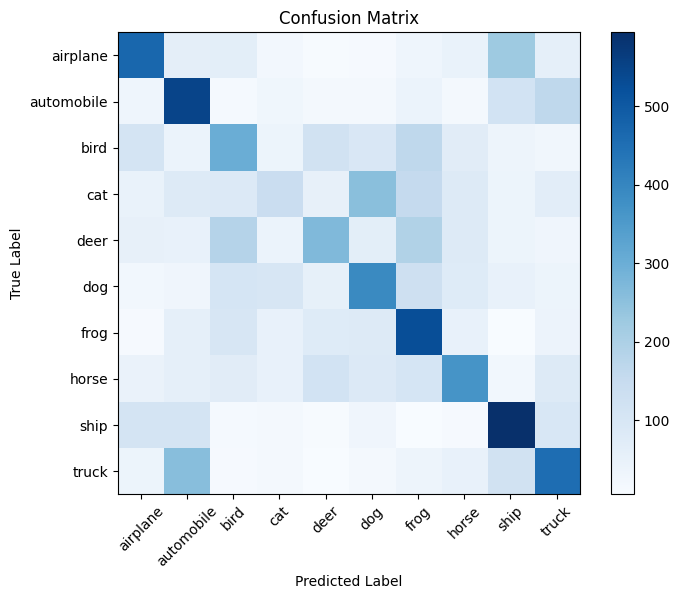

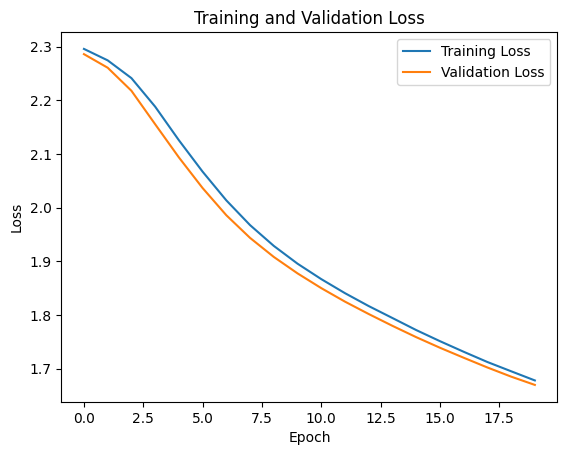

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import random
import numpy as np

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Neural network model
class CIFAR10MLP(nn.Module):
    def __init__(self):
        super(CIFAR10MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 32 * 32, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(64, 10)  # 10 classes in CIFAR-10

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.output_layer(x)
        return x

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define the model and move it to the GPU if available
model = CIFAR10MLP().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Lists for storing loss values and validation accuracy
train_loss_list = []
val_loss_list = []
val_accuracy_list = []

# Training and validation loop
for epoch in range(20):
    running_loss = 0.0
    model.train()  # Set the model to training mode
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss_list.append(running_loss / len(train_loader))

    # Validation loop
    running_loss = 0.0
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss_list.append(running_loss / len(test_loader))
    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Training loss: {train_loss_list[-1]}, Validation loss: {val_loss_list[-1]}, Validation Accuracy: {val_accuracy}%')

# Save the trained model and additional information
save_path = 'cifar10_mlp_model.pth'
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'val_loss_list': val_loss_list,
    'val_accuracy_list': val_accuracy_list
}, save_path)

print(f'Model saved at: {save_path}')

# Print final validation accuracy
print(f'Final Validation Accuracy: {val_accuracy_list[-1]}%')
# Calculate total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

# Calculate accuracy, precision, recall, and F1 score
all_predictions = []
all_targets = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)  # Forward pass
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted classes
        all_predictions.extend(predicted.tolist())
        all_targets.extend(labels.tolist())

# Calculate accuracy, precision, recall, and F1 score
accuracy = 100 * sum([p == t for p, t in zip(all_predictions, all_targets)]) / len(all_targets)
precision = precision_score(all_targets, all_predictions, average='weighted')
recall = recall_score(all_targets, all_predictions, average='weighted')
f1 = f1_score(all_targets, all_predictions, average='weighted')

# Confusion matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)

# Print the metrics and confusion matrix
print(f'Accuracy: {accuracy}%')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

3 Hidden Layers- LR = 0.001 - 100 Epochs

Using device: cuda
Epoch 1, Training loss: 2.288836433759431, Validation loss: 2.272241589370047, Validation Accuracy: 14.95%
Epoch 2, Training loss: 2.2531700957461696, Validation loss: 2.2276206487303325, Validation Accuracy: 24.19%
Epoch 3, Training loss: 2.1969475544931942, Validation loss: 2.1602629491478016, Validation Accuracy: 25.55%
Epoch 4, Training loss: 2.128382923657937, Validation loss: 2.0919109506971516, Validation Accuracy: 26.33%
Epoch 5, Training loss: 2.0648628162301104, Validation loss: 2.0326653893586175, Validation Accuracy: 27.15%
Epoch 6, Training loss: 2.010851839009453, Validation loss: 1.9830121561220497, Validation Accuracy: 28.65%
Epoch 7, Training loss: 1.9648131433960117, Validation loss: 1.940259294904721, Validation Accuracy: 30.56%
Epoch 8, Training loss: 1.9245394750324356, Validation loss: 1.9022786366711757, Validation Accuracy: 32.3%
Epoch 9, Training loss: 1.8895760809673983, Validation loss: 1.8689660934885597, Validation Accuracy: 34.09%
Epoch 

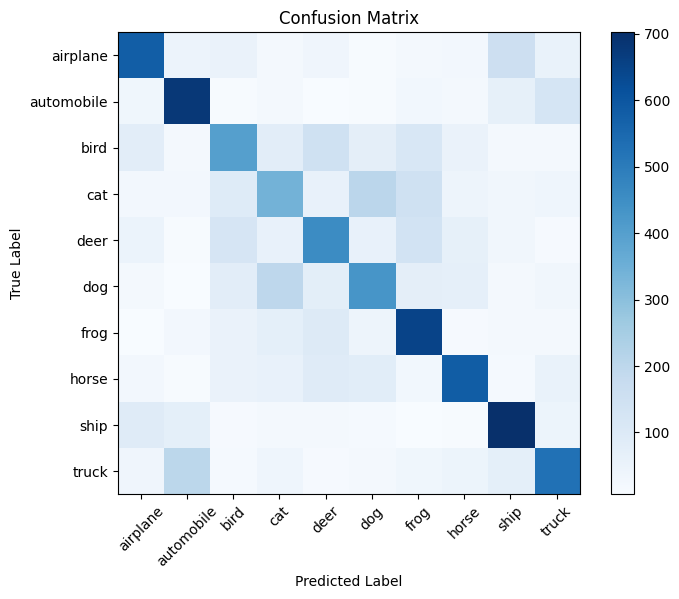

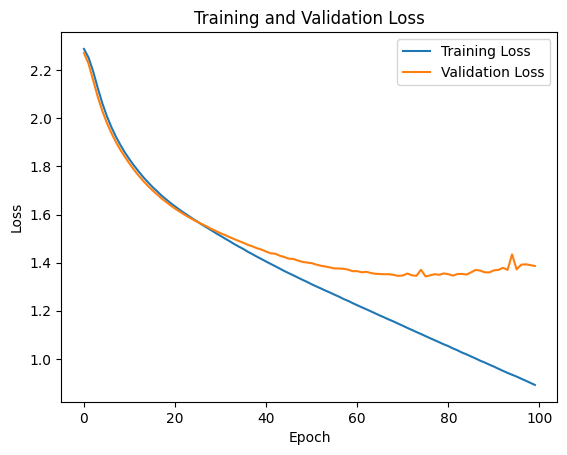

In [ ]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define the model and move it to the GPU if available
model = CIFAR10MLP().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Lists for storing loss values and validation accuracy
train_loss_list = []
val_loss_list = []
val_accuracy_list = []

# Training and validation loop
for epoch in range(100):
    running_loss = 0.0
    model.train()  # Set the model to training mode
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss_list.append(running_loss / len(train_loader))

    # Validation loop
    running_loss = 0.0
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss_list.append(running_loss / len(test_loader))
    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Training loss: {train_loss_list[-1]}, Validation loss: {val_loss_list[-1]}, Validation Accuracy: {val_accuracy}%')

# Save the trained model and additional information
save_path = 'cifar10_mlp_model.pth'
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'val_loss_list': val_loss_list,
    'val_accuracy_list': val_accuracy_list
}, save_path)

print(f'Model saved at: {save_path}')

# Print final validation accuracy
print(f'Final Validation Accuracy: {val_accuracy_list[-1]}%')
# Calculate total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

# Calculate accuracy, precision, recall, and F1 score
all_predictions = []
all_targets = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)  # Forward pass
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted classes
        all_predictions.extend(predicted.tolist())
        all_targets.extend(labels.tolist())

# Calculate accuracy, precision, recall, and F1 score
accuracy = 100 * sum([p == t for p, t in zip(all_predictions, all_targets)]) / len(all_targets)
precision = precision_score(all_targets, all_predictions, average='weighted')
recall = recall_score(all_targets, all_predictions, average='weighted')
f1 = f1_score(all_targets, all_predictions, average='weighted')

# Confusion matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)

# Print the metrics and confusion matrix
print(f'Accuracy: {accuracy}%')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

4 Hidden Layeras - Increased Width - LR = 0.001 - 20 Epochs

Using device: cuda
Epoch 1, Training loss: 2.3022664181716608, Validation loss: 2.2993524439015967, Validation Accuracy: 10.53%
Epoch 2, Training loss: 2.296307534512961, Validation loss: 2.292584748784448, Validation Accuracy: 13.32%
Epoch 3, Training loss: 2.2882282727819576, Validation loss: 2.282838821411133, Validation Accuracy: 16.25%
Epoch 4, Training loss: 2.276035516158394, Validation loss: 2.2672873500046458, Validation Accuracy: 17.57%
Epoch 5, Training loss: 2.255187893157725, Validation loss: 2.2398114827028506, Validation Accuracy: 17.76%
Epoch 6, Training loss: 2.2221163578350525, Validation loss: 2.203438072447564, Validation Accuracy: 19.3%
Epoch 7, Training loss: 2.186989798875111, Validation loss: 2.1698767258103486, Validation Accuracy: 21.28%
Epoch 8, Training loss: 2.154406559131944, Validation loss: 2.1377344480745353, Validation Accuracy: 23.04%
Epoch 9, Training loss: 2.1221408278436003, Validation loss: 2.1046316145332, Validation Accuracy: 24.35%
Epoch 10, Tr

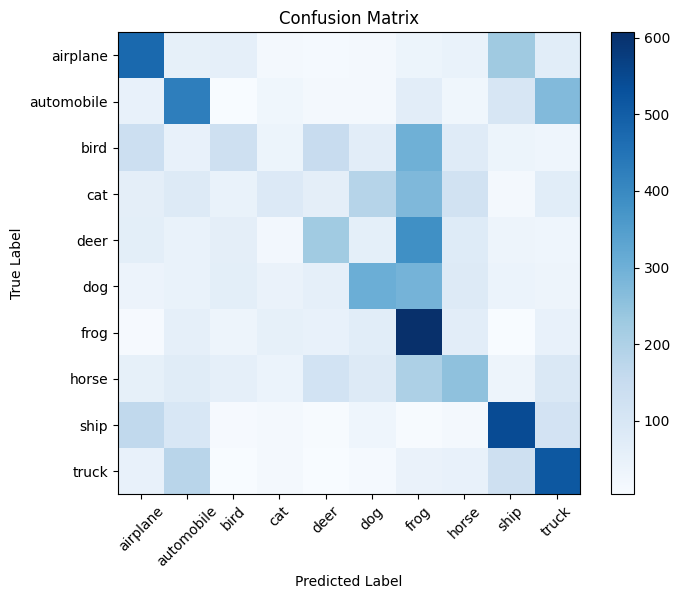

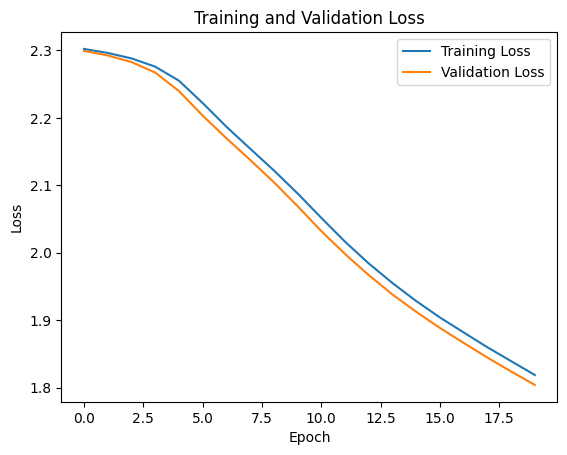

In [ ]:

# Neural network model
class CIFAR10MLP(nn.Module):
    def __init__(self):
        super(CIFAR10MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)  # Increased width
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)  # Increased width
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 128)  # Increased width
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(128, 64)  # Increased depth
        self.relu4 = nn.ReLU()
        self.output_layer = nn.Linear(64, 10)  # 10 classes in CIFAR-10

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)  # Added another hidden layer
        x = self.relu4(x)  # Added another hidden layer
        x = self.output_layer(x)
        return x

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define the model and move it to the GPU if available
model = CIFAR10MLP().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Lists for storing loss values and validation accuracy
train_loss_list = []
val_loss_list = []
val_accuracy_list = []

# Training and validation loop
for epoch in range(20):
    running_loss = 0.0
    model.train()  # Set the model to training mode
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss_list.append(running_loss / len(train_loader))

    # Validation loop
    running_loss = 0.0
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss_list.append(running_loss / len(test_loader))
    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Training loss: {train_loss_list[-1]}, Validation loss: {val_loss_list[-1]}, Validation Accuracy: {val_accuracy}%')

# Save the trained model and additional information
save_path = 'cifar10_mlp_model.pth'
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'val_loss_list': val_loss_list,
    'val_accuracy_list': val_accuracy_list
}, save_path)

print(f'Model saved at: {save_path}')

# Print final validation accuracy
print(f'Final Validation Accuracy: {val_accuracy_list[-1]}%')
# Calculate total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

# Calculate accuracy, precision, recall, and F1 score
all_predictions = []
all_targets = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)  # Forward pass
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted classes
        all_predictions.extend(predicted.tolist())
        all_targets.extend(labels.tolist())

# Calculate accuracy, precision, recall, and F1 score
accuracy = 100 * sum([p == t for p, t in zip(all_predictions, all_targets)]) / len(all_targets)
precision = precision_score(all_targets, all_predictions, average='weighted')
recall = recall_score(all_targets, all_predictions, average='weighted')
f1 = f1_score(all_targets, all_predictions, average='weighted')

# Confusion matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)

# Print the metrics and confusion matrix
print(f'Accuracy: {accuracy}%')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

4 Hidden Layers - Increased Width - L = 0.001 - 100 Epochs


Using device: cuda
Epoch 1, Training loss: 2.3031317663314703, Validation loss: 2.301415748656935, Validation Accuracy: 14.39%
Epoch 2, Training loss: 2.2991322821668345, Validation loss: 2.297157433382265, Validation Accuracy: 15.91%
Epoch 3, Training loss: 2.2945929973021797, Validation loss: 2.2921034120450354, Validation Accuracy: 17.28%
Epoch 4, Training loss: 2.2889958888368533, Validation loss: 2.285530775215975, Validation Accuracy: 18.46%
Epoch 5, Training loss: 2.281306286602069, Validation loss: 2.2762437140106395, Validation Accuracy: 19.83%
Epoch 6, Training loss: 2.269915607884107, Validation loss: 2.2619548785458705, Validation Accuracy: 22.53%
Epoch 7, Training loss: 2.251785240514809, Validation loss: 2.238624733724412, Validation Accuracy: 24.11%
Epoch 8, Training loss: 2.222766527434444, Validation loss: 2.203164263136068, Validation Accuracy: 23.63%
Epoch 9, Training loss: 2.1836063678917066, Validation loss: 2.1606849166238384, Validation Accuracy: 23.38%
Epoch 10,

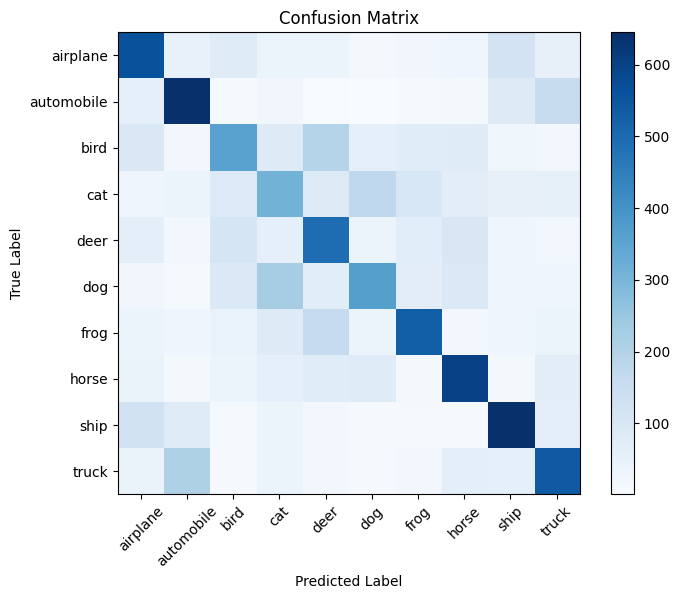

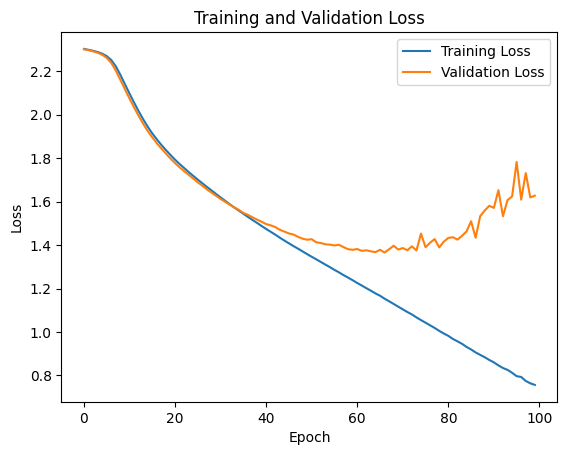

In [ ]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define the model and move it to the GPU if available
model = CIFAR10MLP().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Lists for storing loss values and validation accuracy
train_loss_list = []
val_loss_list = []
val_accuracy_list = []

# Training and validation loop
for epoch in range(100):
    running_loss = 0.0
    model.train()  # Set the model to training mode
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss_list.append(running_loss / len(train_loader))

    # Validation loop
    running_loss = 0.0
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss_list.append(running_loss / len(test_loader))
    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Training loss: {train_loss_list[-1]}, Validation loss: {val_loss_list[-1]}, Validation Accuracy: {val_accuracy}%')

# Save the trained model and additional information
save_path = 'cifar10_mlp_model.pth'
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'val_loss_list': val_loss_list,
    'val_accuracy_list': val_accuracy_list
}, save_path)

print(f'Model saved at: {save_path}')

# Print final validation accuracy
print(f'Final Validation Accuracy: {val_accuracy_list[-1]}%')
# Calculate total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

# Calculate accuracy, precision, recall, and F1 score
all_predictions = []
all_targets = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)  # Forward pass
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted classes
        all_predictions.extend(predicted.tolist())
        all_targets.extend(labels.tolist())

# Calculate accuracy, precision, recall, and F1 score
accuracy = 100 * sum([p == t for p, t in zip(all_predictions, all_targets)]) / len(all_targets)
precision = precision_score(all_targets, all_predictions, average='weighted')
recall = recall_score(all_targets, all_predictions, average='weighted')
f1 = f1_score(all_targets, all_predictions, average='weighted')

# Confusion matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)

# Print the metrics and confusion matrix
print(f'Accuracy: {accuracy}%')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

3 Hidden Layers - Increased Width - LR = 0.001 - 20 Epochs

---



Using device: cuda
Epoch 1, Training loss: 2.287677709098972, Validation loss: 2.2703787506006328, Validation Accuracy: 19.81%
Epoch 2, Training loss: 2.2472476279339215, Validation loss: 2.219600335807557, Validation Accuracy: 23.38%
Epoch 3, Training loss: 2.184654286145554, Validation loss: 2.146568990816736, Validation Accuracy: 24.98%
Epoch 4, Training loss: 2.111716161603513, Validation loss: 2.0737673811092496, Validation Accuracy: 26.71%
Epoch 5, Training loss: 2.0436758839565776, Validation loss: 2.0091871615428074, Validation Accuracy: 28.22%
Epoch 6, Training loss: 1.9851570713245654, Validation loss: 1.956316736093752, Validation Accuracy: 30.0%
Epoch 7, Training loss: 1.9372481328752034, Validation loss: 1.9123987232803539, Validation Accuracy: 31.65%
Epoch 8, Training loss: 1.8966543096715531, Validation loss: 1.8748871467675372, Validation Accuracy: 32.83%
Epoch 9, Training loss: 1.8614361354762026, Validation loss: 1.8412230280554218, Validation Accuracy: 33.88%
Epoch 1

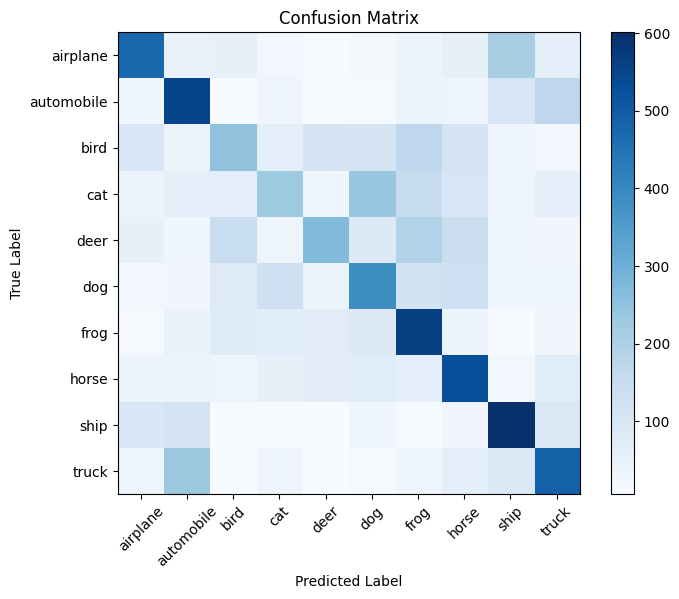

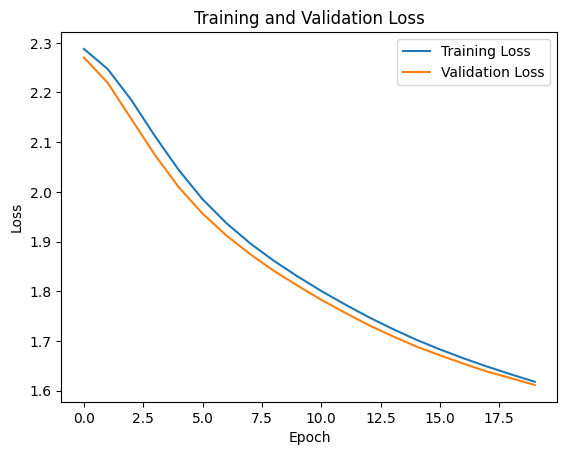

In [ ]:
# Neural network model
class CIFAR10MLP(nn.Module):
    def __init__(self):
        super(CIFAR10MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)  # Increased width
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)  # Increased width
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 128)  # Increased width
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(128, 10)  # 10 classes in CIFAR-10

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.output_layer(x)
        return x

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define the model and move it to the GPU if available
model = CIFAR10MLP().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Lists for storing loss values and validation accuracy
train_loss_list = []
val_loss_list = []
val_accuracy_list = []

# Training and validation loop
for epoch in range(20):
    running_loss = 0.0
    model.train()  # Set the model to training mode
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss_list.append(running_loss / len(train_loader))

    # Validation loop
    running_loss = 0.0
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss_list.append(running_loss / len(test_loader))
    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Training loss: {train_loss_list[-1]}, Validation loss: {val_loss_list[-1]}, Validation Accuracy: {val_accuracy}%')

# Save the trained model and additional information
save_path = 'cifar10_mlp_model.pth'
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'val_loss_list': val_loss_list,
    'val_accuracy_list': val_accuracy_list
}, save_path)

print(f'Model saved at: {save_path}')

# Print final validation accuracy
print(f'Final Validation Accuracy: {val_accuracy_list[-1]}%')
# Calculate total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

# Calculate accuracy, precision, recall, and F1 score
all_predictions = []
all_targets = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)  # Forward pass
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted classes
        all_predictions.extend(predicted.tolist())
        all_targets.extend(labels.tolist())

# Calculate accuracy, precision, recall, and F1 score
accuracy = 100 * sum([p == t for p, t in zip(all_predictions, all_targets)]) / len(all_targets)
precision = precision_score(all_targets, all_predictions, average='weighted')
recall = recall_score(all_targets, all_predictions, average='weighted')
f1 = f1_score(all_targets, all_predictions, average='weighted')

# Confusion matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)

# Print the metrics and confusion matrix
print(f'Accuracy: {accuracy}%')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

3 Hidden Layers - Increased Width - LR = 0.001 - 20 Epochs

Using device: cuda
Epoch 1, Training loss: 2.2848804384241324, Validation loss: 2.2645741663161356, Validation Accuracy: 20.81%
Epoch 2, Training loss: 2.238885778600298, Validation loss: 2.2070161506628536, Validation Accuracy: 24.81%
Epoch 3, Training loss: 2.1731480753330317, Validation loss: 2.1342309067963035, Validation Accuracy: 26.88%
Epoch 4, Training loss: 2.1003964846701266, Validation loss: 2.061712579362711, Validation Accuracy: 28.17%
Epoch 5, Training loss: 2.0328244762042598, Validation loss: 1.9984303606543572, Validation Accuracy: 29.69%
Epoch 6, Training loss: 1.9750711727325263, Validation loss: 1.9450453664087186, Validation Accuracy: 31.38%
Epoch 7, Training loss: 1.9262269264291925, Validation loss: 1.9004905140324004, Validation Accuracy: 32.4%
Epoch 8, Training loss: 1.8849477022505172, Validation loss: 1.8632864595218828, Validation Accuracy: 33.7%
Epoch 9, Training loss: 1.849530250672489, Validation loss: 1.829909020168766, Validation Accuracy: 35.04%
Epoch 

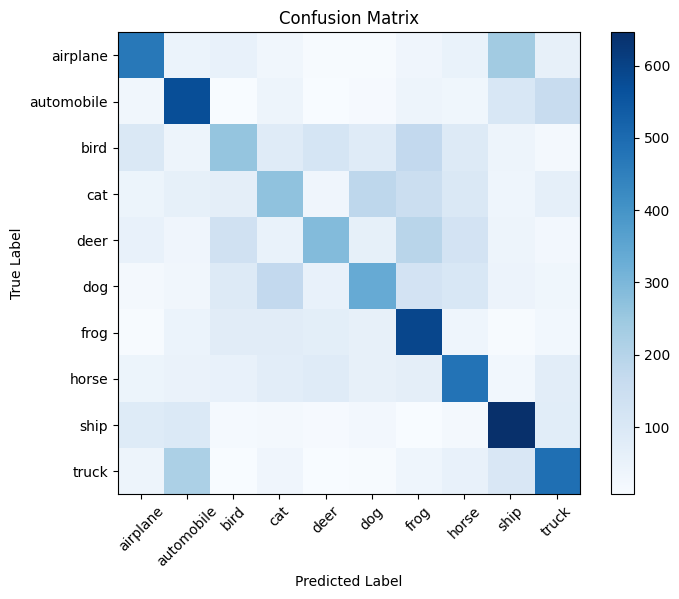

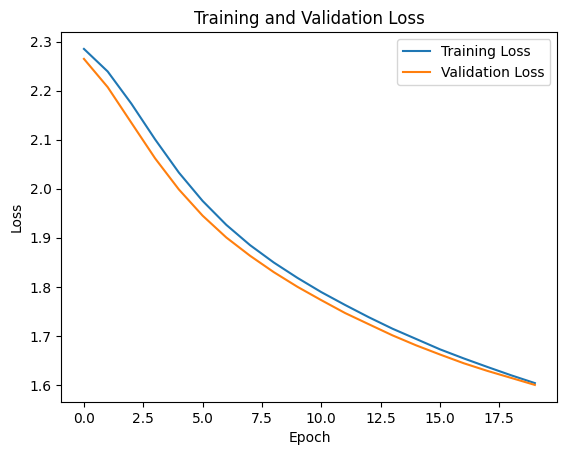

In [ ]:
# Neural network model
class CIFAR10MLP(nn.Module):
    def __init__(self):
        super(CIFAR10MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 32 * 32, 1024)  # Increased width
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 512)  # Increased width
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 256)  # Increased width
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(256, 10)  # 10 classes in CIFAR-10

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.output_layer(x)
        return x

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define the model and move it to the GPU if available
model = CIFAR10MLP().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Lists for storing loss values and validation accuracy
train_loss_list = []
val_loss_list = []
val_accuracy_list = []

# Training and validation loop
for epoch in range(20):
    running_loss = 0.0
    model.train()  # Set the model to training mode
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss_list.append(running_loss / len(train_loader))

    # Validation loop
    running_loss = 0.0
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss_list.append(running_loss / len(test_loader))
    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Training loss: {train_loss_list[-1]}, Validation loss: {val_loss_list[-1]}, Validation Accuracy: {val_accuracy}%')

# Save the trained model and additional information
save_path = 'cifar10_mlp_model.pth'
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'val_loss_list': val_loss_list,
    'val_accuracy_list': val_accuracy_list
}, save_path)

print(f'Model saved at: {save_path}')

# Print final validation accuracy
print(f'Final Validation Accuracy: {val_accuracy_list[-1]}%')
# Calculate total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

# Calculate accuracy, precision, recall, and F1 score
all_predictions = []
all_targets = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)  # Forward pass
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted classes
        all_predictions.extend(predicted.tolist())
        all_targets.extend(labels.tolist())

# Calculate accuracy, precision, recall, and F1 score
accuracy = 100 * sum([p == t for p, t in zip(all_predictions, all_targets)]) / len(all_targets)
precision = precision_score(all_targets, all_predictions, average='weighted')
recall = recall_score(all_targets, all_predictions, average='weighted')
f1 = f1_score(all_targets, all_predictions, average='weighted')

# Confusion matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)

# Print the metrics and confusion matrix
print(f'Accuracy: {accuracy}%')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()